**Instruction for POS Tagging Using RNNs with Arabic Dataset**

**Dataset:**
The dataset provided is named "Arabic POS.conllu". It contains labeled data for Arabic text with Part-of-Speech (POS) tags in CoNLL-U format.

**Objective:**
Your objective is to perform Part-of-Speech (POS) tagging on Arabic text using Recurrent Neural Networks (RNNs). Specifically, you will use the Universal POS (UPOS) tags for tagging. UPOS is a standardized set of POS tags that aims to cover all languages.

**Evaluation metric:**
Accuracy

**Instructions:**
1. **Data Preprocessing:**
   - Load the provided dataset "Arabic POS.conllu". You can use pyconll library
   - Preprocess the data as necessary, including tokenization

2. **Model Building:**
   - Design an RNN-based model architecture suitable for POS tagging. You may consider using recurrent layers such as (LSTM) or (GRU).
   - Define the input and output layers of the model. The input layer should accept sequences of tokens, and the output layer should produce the predicted UPOS tags for each token.

3. **Training:**

4. **Evaluation:**

### Import used libraries

In [3]:
!pip install pyconll
!pip install nltk

In [8]:
import pyconll
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from tqdm import tqdm
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import make_scorer,accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

### Load Dataset

In [85]:
file_path = '/kaggle/input/arabic-pos/Arabic POS.conllu'
corpus = pyconll.load_from_file(file_path)

In [291]:
tokens = []
pos = []
sentences = []  
sentence_id = []  
current_sentence_id = 1 

for sentence in corpus:
    sentence_tokens = []  # Tokens for each sentence
    for token in sentence:
         
        if token.upos is None or token.form is None:
            continue
        else:
            
            pos.append(token.upos)   
            tokens.append(token.form) 
        sentence_id.append(f"Sentence: {current_sentence_id}")
        sentence_tokens.append(token.form)  
    current_sentence_id +=1 
    sentences.append(' '.join(sentence_tokens))  # Join tokens to form sentence and append to sentences list

#### Handling Words with Missing POS Tags

- There were some words with POS tags equal to `None` . 
- To prevent these instances from affecting the model's performance, we made the decision to ignore them during data processing. 
- By excluding words with missing POS tags, we help to maintain the integrity of the dataset and ensure that the model's predictions are not biased by incomplete  information.

In [12]:
sentences[:5]

['برلين ترفض حصول شركة اميركية على رخصة تصنيع دبابة " ليوبارد " الالمانية',
 'برلين 15 - 7 ( اف ب ) - افادت صحيفة الاحد الالمانية " ويلت ام سونتاغ " في عدد ها الصادر غدا ، ان المستشار غيرهارد شرودر يرفض حصول المجموعة الاميركية " جنرال ديناميكس " على رخصة ل تصنيع الدبابة الالمانية " ليوبارد 2 " عبر شراء المجموعة الحكومية الاسبانية ل الأسلحة " سانتا بربارة " .',
 'و في نيسان / ابريل الماضي ، تخلت الدولة الاسبانية عن مجموعة " سانتا بربارة " التي تصنع دبابات ليوبارد الالمانية ، الى " جنرال ديناميكس " التي تنتج الدبابة الاميركية " ام 1 ابرامس " المعتبرة المنافسة الرئيسية ل دبابة ليوبارد في الاسواق .',
 'و كانت خسائر المجموعة الاسبانية الرسمية تراكمت في السنوات العشر الاخيرة ل تبلغ 920 مليون يورو .',
 'و أشارت صحيفة الاحد الى ان المستشار شرودر يعتبر ان حصول المجموعة الاميركية على رخصة تصنيع ليوبارد 2 يعرض ل الخطر المصالح التكنولوجية الاساسية ل ألمانيا و طلب من وزير الدفاع رودولف شاربينغ التوجه الى اسبانيا .']

- We've to extract the tokens and the corresponding Universal POS tags 

In [292]:
df = pd.DataFrame({"Sentence #": sentence_id,
                   "WORD": tokens,
                   "POS": pos})
df.ffill()
df.head(15)

,Sentence #,WORD,POS
0,Sentence: 1,برلين,X
1,Sentence: 1,ترفض,VERB
2,Sentence: 1,حصول,NOUN
3,Sentence: 1,شركة,NOUN
4,Sentence: 1,اميركية,ADJ
5,Sentence: 1,على,ADP
6,Sentence: 1,رخصة,NOUN
7,Sentence: 1,تصنيع,NOUN
8,Sentence: 1,دبابة,NOUN
9,Sentence: 1,"""",PUNCT


In [293]:
print("Unique words in corpus:", df['WORD'].nunique())
print("Unique tags in corpus:", df['POS'].nunique())

Unique words in corpus: 21915
Unique tags in corpus: 17


- We have various POS such as "PUNCT" which represents punctuation marks, and "NOUN", "VERB", "ADJ", and "ADP" represent nouns, verbs, adjectives, and adpositions.
- Here is a reference table outlining the meanings of different Parts of Speech (POS) tags exist in the data:

| POS   | Meaning                                                   |
|-------|-----------------------------------------------------------|
| NOUN  | Person, place, thing, or idea                             |
| ADP   | Preposition or postposition                                |
| ADJ   | Modifies or describes a noun or pronoun                   |
| PUNCT | Punctuation marks                                         |
| VERB  | Expresses an action, occurrence, or state of being        |
| CCONJ | Coordinating conjunction                                  |
| X     | Placeholder or symbol                                     |
| PRON  | Substitutes for a noun or noun phrase                     |
| NUM   | Number                                                    |
| DET   | Introduces a noun and expresses reference                 |
| SCONJ | Introduces subordinate clauses                            |
| PART  | Grammatically functional word not fitting major categories|
| AUX   | Auxiliary verb                                            |
| ADV   | Modifies a verb, adjective, adverb, clause, or sentence  |
| SYM   | Mathematical or logical symbol                            |
| PROPN | Proper noun                                               |
| INTJ  | Interjection expressing emotion or sentiment              |


In [294]:
df.shape

(223881, 3)

In [295]:
df['POS'].value_counts()

POS
NOUN     74546
ADP      33617
ADJ      23498
PUNCT    17511
VERB     16789
CCONJ    15803
X        13747
PRON      8533
NUM       6010
DET       4648
SCONJ     4368
PART      1709
AUX       1699
ADV        880
SYM        329
PROPN      187
INTJ         7
Name: count, dtype: int64

- NOUN is the most frequent POS tag (74546) , followed by ADP (33617) and ADJ (23498).

### Cleaning and Preprocessing

In [296]:
def clean_str(text):

    # Remove longation
    text = re.sub(r'(.)\1+', r"\1\1", text) 
    
    # Text normalization
    text = re.sub("[إأآااً]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub("ڤ", "ف", text)
    text = re.sub("چ", "ج", text)
    text = re.sub("ژ", "ز", text)
    text = re.sub("پ", "ب", text)
    
    return text

In [297]:
# Clean each token in corpus to obtain unique words
cleaned_tokens = list(map(clean_str,tokens))

cleaned_tokens[:5]

['برلين', 'ترفض', 'حصول', 'شركه', 'اميركيه']

In [298]:
unique_tokens = set(cleaned_tokens)
print("Number of unique tokens:",len(unique_tokens))

Number of unique tokens: 20613


In [299]:
df['CLEAN_WORDS'] = cleaned_tokens

In [300]:
df.head()

,Sentence #,WORD,POS,CLEAN_WORDS
0,Sentence: 1,برلين,X,برلين
1,Sentence: 1,ترفض,VERB,ترفض
2,Sentence: 1,حصول,NOUN,حصول
3,Sentence: 1,شركة,NOUN,شركه
4,Sentence: 1,اميركية,ADJ,اميركيه


In [301]:
# Before removing duplicates
df.shape

(223881, 4)

In [302]:
df.duplicated(subset=['CLEAN_WORDS','POS']).sum()

201020

In [303]:
# df.drop_duplicates(subset=['CLEAN_WORDS','POS'],inplace = True)

In [304]:
# After removing duplicates
df.shape

(223881, 4)

In [305]:
df['POS'].value_counts()

POS
NOUN     74546
ADP      33617
ADJ      23498
PUNCT    17511
VERB     16789
CCONJ    15803
X        13747
PRON      8533
NUM       6010
DET       4648
SCONJ     4368
PART      1709
AUX       1699
ADV        880
SYM        329
PROPN      187
INTJ         7
Name: count, dtype: int64

In [306]:
df.loc[df['POS']=='SCONJ','POS'] = 'ADP'

- We can comibne SCONJ with the ADP (Preposition or Postposition) class to prevent causing errors.

In [307]:
df.loc[df['POS']=='SYM']

,Sentence #,WORD,POS,CLEAN_WORDS
1042,Sentence: 42,%,SYM,%
1374,Sentence: 53,%,SYM,%
1432,Sentence: 55,%,SYM,%
1437,Sentence: 55,%,SYM,%
1472,Sentence: 56,%,SYM,%
...,...,...,...,...
188809,Sentence: 4894,/,SYM,/
190354,Sentence: 4941,/,SYM,/
191015,Sentence: 4962,/,SYM,/
191019,Sentence: 4962,/,SYM,/


In [308]:
df.tail()

,Sentence #,WORD,POS,CLEAN_WORDS
223876,Sentence: 6075,بنية,NOUN,بنيه
223877,Sentence: 6075,ه,PRON,ه
223878,Sentence: 6075,التحتية,ADJ,التحتيه
223879,Sentence: 6075,"""",PUNCT,""""
223880,Sentence: 6075,.,PUNCT,.


- We can add more symbols to balance the data

In [309]:
additional_symbols = pd.DataFrame({
    'Sentence #': ['Sentence: 6074']*5,  # Add sentence numbers for new instances
    'WORD': ['-', '>', '*', '=', '^'],           # Add additional symbol instances
    'POS': ['SYM']*5,  # Label them as symbols
    'CLEAN_WORDS': ['-', '>', '*', '=', '^']  
})

# Concatenate the additional symbols DataFrame with the existing DataFrame
df = pd.concat([df, additional_symbols],axis=0, ignore_index=True)

In [310]:
df['POS'].value_counts()

POS
NOUN     74546
ADP      37985
ADJ      23498
PUNCT    17511
VERB     16789
CCONJ    15803
X        13747
PRON      8533
NUM       6010
DET       4648
PART      1709
AUX       1699
ADV        880
SYM        334
PROPN      187
INTJ         7
Name: count, dtype: int64

### Retrieve Sentences and Corresponsing Pos

In [311]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p) for w, p in zip(s["CLEAN_WORDS"].values.tolist(),
                                                     s["POS"].values.tolist())]
        
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [312]:
getter = SentenceGetter(df)
sentences = getter.sentences

/tmp/ipykernel_34/593768635.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [313]:
sentences[0]

[('برلين', 'X'),
 ('ترفض', 'VERB'),
 ('حصول', 'NOUN'),
 ('شركه', 'NOUN'),
 ('اميركيه', 'ADJ'),
 ('علي', 'ADP'),
 ('رخصه', 'NOUN'),
 ('تصنيع', 'NOUN'),
 ('دبابه', 'NOUN'),
 ('"', 'PUNCT'),
 ('ليوبارد', 'X'),
 ('"', 'PUNCT'),
 ('الالمانيه', 'ADJ')]

In [314]:
words = list(set(df["CLEAN_WORDS"].values))
words.append("ENDPAD")
num_words = len(words)
num_words

20617

In [315]:
pos = list(set(df["POS"].values))
num_pos = len(pos)

### Define Mappings between Sentences and Pos

* Create tokens and POS encoders

In [316]:
# starting from 1 , to set 0 default index for out of vocab
word2idx = {w: i + 1 for i, w in enumerate(words)}
pos2idx = {t: i for i, t in enumerate(pos)}

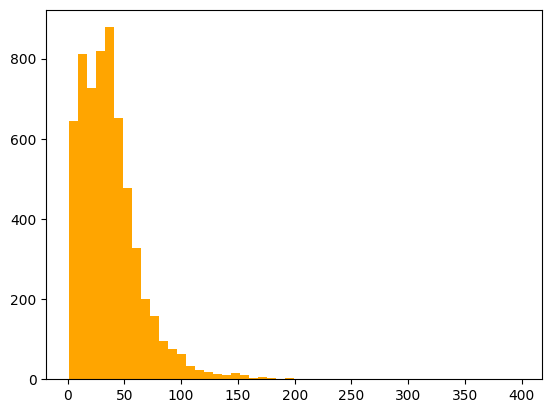

In [317]:
plt.hist([len(s) for s in sentences], bins=50, color = 'orange')
plt.show()

- Setting max_len to be 25.

In [318]:
max_len = 150

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value = num_words-1) # Index of ENDPAD

y = [[pos2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value = pos2idx['X'] )

In [319]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modelling

- Assigning `return_sequences=True` is a must, to enable the subsequent layer "TimeDistributed" to receive and process information from each time step, where each input token needs to be associated with an output label.

In [320]:
input_word = Input(shape=(max_len,))

# Embedding layer to convert input word to vectors
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)

# Bidirectional LSTM layer to capture context from both directions , 
model = Bidirectional(LSTM(50, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))(model)

# TimeDistributed layer to apply Dense layer to each time step independently
out = TimeDistributed(Dense(num_pos, activation="softmax"))(model)

model = Model(input_word, out)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 150, 50)        │     1,030,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 150, 100)       │        40,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 150, 16)        │         1,616 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,866 (4.09 MB)

 Trainable params: 1,072,866 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [321]:
# Using "sparse_categorical_crossentropy" instead of one hot encode labels
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [322]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=50,
    callbacks=[early_stopping])

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 366ms/step - accuracy: 0.7768 - loss: 0.9143 - val_accuracy: 0.8946 - val_loss: 0.3648
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 357ms/step - accuracy: 0.9099 - loss: 0.2985 - val_accuracy: 0.9521 - val_loss: 0.1603
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 357ms/step - accuracy: 0.9627 - loss: 0.1344 - val_accuracy: 0.9795 - val_loss: 0.0783
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 355ms/step - accuracy: 0.9855 - loss: 0.0645 - val_accuracy: 0.9844 - val_loss: 0.0568
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 354ms/step - accuracy: 0.9910 - loss: 0.0405 - val_accuracy: 0.9852 - val_loss: 0.0494
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 356ms/step - accuracy: 0.9924 - loss: 0.0312 - val_accuracy: 0.9860 - val_loss: 0.0465
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 357ms/step - accuracy: 0.9932 - loss: 0.0256 - val_accuracy: 0.9862 - val_loss: 0.0450
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 360ms/step - accuracy: 0.9934 - loss: 0

#### Evaluation

**Evaluation metric:**
Accuracy

In [324]:
# Loss and precision on validation data 
evaluation_metrics = model.evaluate(x_test,
                                    y_test, verbose=0)
loss = evaluation_metrics[0]
acc = evaluation_metrics[1]

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test Loss: 0.044051289558410645
Test Accuracy: 0.9864582419395447


In [325]:
x_test.shape

(1215, 150)

In [326]:
# Generate predictions using the trained model on the test dataset.
predictions= model.predict(x_test, verbose=0)

In [327]:
# Select the class with the highest probability as the predicted pos
predicted_labels = np.argmax(predictions, axis=-1)

In [328]:
print('Test shape:',x_test.shape)
print('Predictions shape:', predictions.shape)

Test shape: (1215, 150)
Predictions shape: (1215, 150, 16)


In the case of POS tagging, the predictions tensor has shape (no_samples, sequence_length, num_classes).
* Where:
    * no_samples is the number of samples in the batch.
    * sequence_length is the length of each sequence.
    * num_classes is the number of classes (the number of POS tags -16- ).
* By setting axis=-1, we compute the argmax along the last axis, which corresponds to the num_classes axis. This means that for each element in the batch and for each position in the sequence, np.argmax will return the index of the class with the highest probability.

In [329]:
# Ignore zeros to prevent biased evaluation
mask = y_test.flatten() != pos2idx['X']
y_test_flat = y_test.flatten()[mask]
predicted_labels_flat = predicted_labels.flatten()[mask]

In [330]:
print(classification_report(y_test_flat ,predicted_labels_flat, zero_division=1))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       343
           1       1.00      0.99      0.99      3205
           2       0.96      0.90      0.93      3307
           3       0.98      1.00      0.99      7408
           4       0.86      0.80      0.83       333
           5       1.00      1.00      1.00      3586
           6       1.00      0.90      0.94      1212
           7       0.95      0.91      0.93      4784
           8       0.98      0.96      0.97       894
           9       0.92      0.32      0.48        37
          10       0.99      0.87      0.93       182
          11       1.00      0.94      0.97        50
          12       1.00      0.00      0.00         1
          13       1.00      0.99      0.99      1686
          14       0.96      0.96      0.96     14893
          15       0.00      1.00      0.00         0

    accuracy                           0.96     41921
   macro avg       0.91   

In [331]:
metrics = pd.DataFrame(history.history)

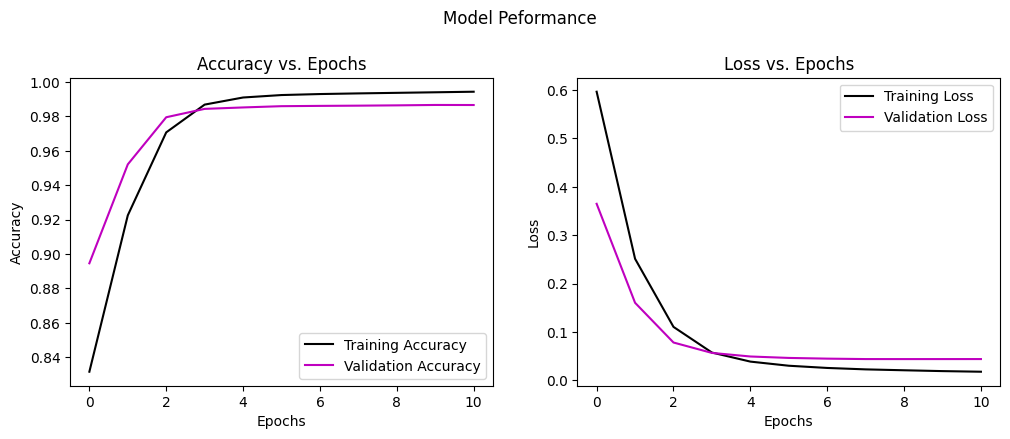

In [332]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(metrics['accuracy'], label='Training Accuracy',color='k')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy',color='m')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics['loss'], label='Training Loss',color='k')
plt.plot(metrics['val_loss'], label='Validation Loss',color='m')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs. Epochs")
plt.legend()
plt.suptitle('Model Peformance', y = 1.05)
plt.show()

### Conclusion and final results


In [333]:
def predict(text):
    max_len = 150
    str_len = len(text.split())
    # 0 is the default index for unknown pos
    text = clean_str(text)
    text = [[word2idx[w] for w in text.split() if w != "ENDPAD"]]
    text = pad_sequences(maxlen=max_len, sequences=text, padding="post",value = num_words-1)
    p = model.predict(np.array([text[0]]))
    p = np.argmax(p, axis=-1)
    print("{:15}\t {}\n".format("Word", "Pred"))
    print("-" *30)
    for i in range(str_len):
        print("{:15}\t{}".format(words[text[0][i]-1], pos[p[0][i]]))

In [334]:
text ='برلين ترفض حصول شركة اميركية على رخصة تصنيع دبابة " ليوبارد " الالمانية'
predict(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Word           	 Pred

------------------------------
برلين          	X
ترفض           	VERB
حصول           	NOUN
شركه           	NOUN
اميركيه        	ADJ
علي            	ADP
رخصه           	NOUN
تصنيع          	NOUN
دبابه          	NOUN
"              	PUNCT
ليوبارد        	X
"              	PUNCT
الالمانيه      	ADJ
